# 개요

## function

### parse_nth_segment_info_from_file

In [1]:
from pathlib import Path
from typing import Optional, Tuple
from typing import Tuple

# 반환 타입이 확장되어 (레이블, 시작 프레임, 종료 프레임, 촬영 각도, 동작 이름)이 됩니다.
def parse_nth_segment_info_from_file(txt_path: Path, num: int = 1) -> Optional[Tuple[str, int, int, str, str]]:
    # 순서 번호(num) 유효성 검사
    if num <= 0:
        print("[ERROR] 순서 번호(num)는 1 이상이어야 합니다.")
        return None
        
    data_line = "" # ValueError에서 참조할 수 있도록 초기화
    
    try:
        # 1. 파일 내용 읽기
        with open(txt_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        valid_lines = []
        # 2. 주석 (#) 라인과 빈 라인을 제외한 유효한 데이터 라인만 수집
        for line in lines:
            line = line.strip()
            if line and not line.startswith('#'):
                valid_lines.append(line)
        
        # 요청된 세그먼트가 존재하는지 확인
        if len(valid_lines) < num:
            print(f"[ERROR] 파일에 유효한 세그먼트 데이터가 {len(valid_lines)}개 있습니다. {num}번째 세그먼트는 존재하지 않습니다.")
            return None

        # 3. N번째 데이터 라인 파싱 (리스트 인덱스는 num - 1)
        data_line = valid_lines[num - 1]
        
        # 쉼표 또는 공백으로 구분된 데이터를 파싱
        # 예시: "frontal__biceps_curl__1 390 1860"
        parts = data_line.replace(',', ' ').split() 
        
        if len(parts) < 3:
            print(f"[ERROR] 데이터 라인 형식이 'label, start, end'가 아닙니다: {data_line}")
            return None

        # 4. 프레임 정보 추출 및 타입 변환
        full_label = parts[0].strip()
        start_frame = int(parts[1].strip())
        end_frame = int(parts[2].strip())
        
        # 5. 레이블 세분화 (추가된 부분)
        # full_label: "frontal__biceps_curl__1"을 "__" 기준으로 분리
        label_parts = full_label.split('__')
        
        if len(label_parts) >= 3:
            # 촬영 각도(예: frontal)
            view_angle = label_parts[0].strip()
            # 동작 이름(예: biceps_curl)
            action_name = label_parts[1].strip()
            # 세트 번호(예: 1) - 현재는 사용하지 않으므로 포함하지 않아도 되지만, 
            # 일관성을 위해 label_parts[2]는 무시하고 촬영각도와 동작 이름만 반환합니다.
        elif len(label_parts) == 2:
             # 구분자가 부족할 경우 예외 처리
            view_angle = label_parts[0].strip()
            action_name = label_parts[1].strip()
            print(f"[WARN] 세트 번호(__1)가 없는 레이블 형식입니다. ({full_label})")
        else:
            # 레이블 형식이 'A__B__C'가 아닌 경우
            print(f"[WARN] 레이블 형식(A__B__C)이 예상과 다릅니다. 전체 레이블 사용: {full_label}")
            view_angle = "UNKNOWN"
            action_name = full_label
            
        # 전체 레이블, 시작, 종료, 촬영각도, 동작이름을 반환
        return full_label, start_frame, end_frame, view_angle, action_name
            
    except FileNotFoundError:
        print(f"[FATAL] TXT 파일 찾을 수 없음: {txt_path}")
        return None
    except ValueError as e:
        # 프레임 번호 변환 오류 시 data_line을 표시
        print(f"[ERROR] 프레임 번호 변환 오류. 데이터 라인({data_line})을 확인하세요. 오류: {e}")
        return None
    except Exception as e:
        print(f"[ERROR] 예기치 않은 오류 발생: {e}")
        return None

### extract_info_from_path


In [2]:
from pathlib import Path
from typing import Tuple

# --- 💡 기존의 parse_label_details 함수 재사용 ---
def parse_label_details(full_label: str) -> Tuple[str, str]:
    """
    전체 레이블(예: 'frontal__biceps_curl__1')을 촬영 각도와 동작 이름으로 분리합니다.
    """
    label_parts = full_label.split('__')
    
    view_angle = "UNKNOWN"
    action_name = full_label
    
    if len(label_parts) >= 3:
        # A__B__C 형식 (각도__동작__세트)
        view_angle = label_parts[0].strip()
        action_name = label_parts[1].strip()
    elif len(label_parts) == 2:
        # A__B 형식 (각도__동작)
        view_angle = label_parts[0].strip()
        action_name = label_parts[1].strip()
    else:
        pass
        
    return view_angle, action_name
# ----------------------------------------------------


def extract_info_from_path(abs_path: str) -> Tuple[str, str, str]:
    """
    절대 경로에서 확장자가 제거된 파일명(레이블), 촬영 각도, 동작 이름을 추출하여 반환합니다.

    Args:
        abs_path (str): 분석할 절대 경로 문자열.
        예: /workspace/.../ICU_sample_video/frontal__shoulder_abduction__1.MP4

    Returns:
        Tuple[str, str, str]: (확장자 제거된 레이블 문자열, 촬영각도, 동작이름)
    """
    
    path_obj = Path(abs_path)
    
    # 1. 확장자를 제거한 파일명 (순수한 레이블 문자열) 추출
    # .stem 속성을 사용하면 파일명에서 확장자가 제거됩니다.
    label_string = path_obj.stem # 예: frontal__shoulder_abduction__1
    
    # 2. 레이블 세분화 함수를 사용하여 각도와 동작 이름 추출
    view_angle, action_name = parse_label_details(label_string)
        
    # 3. 반환 순서: 순수한 레이블 문자열, 각도, 동작 이름
    return label_string, view_angle, action_name

### render_skeleton_video

In [3]:
import sys
sys.path.append("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/ASAN_01_Repeatition_Counter")

import cv2
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm
from typing import Optional, List, Any
from functions.constants_skeleton.registry import load_skeleton_constants

def render_skeleton_video(
    frame_dir: str,
    json_dir: str,
    out_mp4: str,
    start_frame: Optional[int] = None, # <--- 구간 시작 번호
    end_frame: Optional[int] = None,   # <--- 구간 종료 번호
    fps: int = 30,
    kp_radius: int = 4,
    line_thickness: int = 2,
    model_type: str = "coco17",
    flip_horizontal: bool = True
):
    """
    프레임 + keypoints JSON → skeleton overlay mp4 생성
    - start_frame, end_frame이 지정되면 해당 구간만 처리합니다.
    - 프레임 파일명은 6자리 0-패딩 (예: 000000.jpg)을 가정합니다.
    - model_type: 'coco17', 'yolo12' 등 constants_skeleton에서 로드
    - flip_horizontal: 좌우 반전 여부 (기본 False)
    """
    frame_dir_path = Path(frame_dir)
    json_dir_path = Path(json_dir)
    out_mp4_path = Path(out_mp4)
    out_mp4_path.parent.mkdir(parents=True, exist_ok=True)
    
    frame_files: List[Path] = []
    
    # 1. 처리할 프레임 파일 목록 결정
    if start_frame is not None and end_frame is not None and start_frame <= end_frame:
        # Case 1: 시작/종료 번호가 지정된 경우
        frame_numbers = range(start_frame, end_frame + 1)
        # 6자리 0-패딩 파일명으로 경로를 생성합니다.
        frame_files = [frame_dir_path / f"{fn:06d}.jpg" for fn in frame_numbers]
        print(f"[INFO] Rendering segment: Frames {start_frame} to {end_frame} ({len(frame_files)} expected).")
    else:
        # Case 2: 전체 프레임 처리 (기존 glob 동작)
        frame_files = sorted(frame_dir_path.glob("*.jpg"))
        
        if frame_files:
            first = frame_files[0].stem
            last = frame_files[-1].stem
            print(f"[INFO] Rendering all frames ({len(frame_files)} found). Range: {first} to {last}.")
        else:
            print(f"[WARN] No frames found in {frame_dir_path} directory.")
            return

    # 2. 상수 로드
    const = load_skeleton_constants(model_type)
    COLOR_SK = const.COLOR_SK
    COLOR_L = const.COLOR_L
    COLOR_R = const.COLOR_R
    COLOR_NEUTRAL = const.COLOR_NEUTRAL
    LEFT_POINTS = const.LEFT_POINTS
    RIGHT_POINTS = const.RIGHT_POINTS
    EXCLUDE_POINTS = getattr(const, "EXCLUDE_POINTS", [])
    SKELETON_LINKS = getattr(const, "SKELETON_LINKS", [])

    # 3. 해상도 확인 및 VideoWriter 설정
    # 실제로 존재하는 프레임만 필터링하여 첫 번째 프레임으로 사용
    valid_frame_paths = [p for p in frame_files if p.exists()]
    if not valid_frame_paths:
         print("[WARN] No actual frame files exist in the specified range.")
         return
         
    sample = cv2.imread(str(valid_frame_paths[0]))
    # ⚠️ 사용자의 요청에 따라 첫 번째 프레임 로드 실패 시 오류 처리 코드를 제거했습니다.
    # if sample is None:
    #     print(f"[ERROR] Could not read first valid frame: {valid_frame_paths[0]}")
    #     return
        
    h, w = sample.shape[:2]
    
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_mp4_path), fourcc, fps, (w, h))
    
    if not writer.isOpened():
        print(f"[ERROR] VideoWriter failed to open. Check codec/path: {out_mp4_path}")
        return

    # 4. 프레임 순회 및 렌더링
    for frame_path in tqdm(frame_files, total=len(frame_files),
                           desc=f"Rendering to {out_mp4_path.name}", unit="frame"):
                           
        if not frame_path.exists():
            continue # 해당 프레임이 지정된 구간에 없으면 건너뛰기

        frame = cv2.imread(str(frame_path))
        if frame is None:
            continue
            
        json_path = json_dir_path / (frame_path.stem + ".json")

        if not json_path.exists():
            writer.write(frame)
            continue

        # JSON 로드 및 렌더링
        try:
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            if "instance_info" in data and len(data["instance_info"]) > 0:
                for person in data["instance_info"]:
                    kpts = np.array(person.get("keypoints", []))

                    if kpts.ndim != 2 or kpts.shape[0] == 0:
                        continue

                    # Skeleton 라인
                    for i, j in SKELETON_LINKS:
                        if i >= len(kpts) or j >= len(kpts) or i in EXCLUDE_POINTS or j in EXCLUDE_POINTS:
                            continue
                        
                        # 좌표 유효성 검사 (0보다 큰 값)
                        pt1_x, pt1_y = kpts[i]
                        pt2_x, pt2_y = kpts[j]
                        if pt1_x <= 0 or pt1_y <= 0 or pt2_x <= 0 or pt2_y <= 0:
                             continue
                             
                        pt1, pt2 = tuple(map(int, kpts[i])), tuple(map(int, kpts[j]))
                        cv2.line(frame, pt1, pt2, COLOR_SK, line_thickness)

                    # Keypoints 점
                    for idx, (x, y) in enumerate(kpts):
                        if idx in EXCLUDE_POINTS or x <= 0 or y <= 0:
                            continue
                        if idx in LEFT_POINTS:
                            color = COLOR_L
                        elif idx in RIGHT_POINTS:
                            color = COLOR_R
                        else:
                            color = COLOR_NEUTRAL
                        cv2.circle(frame, (int(x), int(y)), kp_radius, color, -1)
        except Exception as e:
            print(f"[WARN] JSON processing error for {frame_path.stem}: {e}")
            # 오류 발생 시 스켈레톤 없이 원본 프레임만 기록
            pass 

        # 안내 문구 및 프레임 번호 표시
        frame_num_int = int(frame_path.stem)
        legend_text = f"L: Blue | R: Red | Frame: {frame_num_int}"
        cv2.putText(frame, legend_text, (20, h - 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2, cv2.LINE_AA)

        # 좌우 반전 (선택)
        if flip_horizontal:
            frame = cv2.flip(frame, 1)

        writer.write(frame)

    writer.release()
    print(f"✅ Skeleton overlay 완료 → {out_mp4_path}")

### load_kpt

In [4]:
import json
import numpy as np
from pathlib import Path
import re # 정규 표현식 모듈 추가
from typing import List, Tuple, Dict, Any, Optional

def load_kpt(
    json_dir: str,
    start_frame: Optional[int] = None, # Optional로 변경
    end_frame: Optional[int] = None    # Optional로 변경
) -> Dict[str, Any]:
    """
    지정된 디렉토리에서 키포인트 JSON 파일을 로드합니다.
    start_frame, end_frame이 None이면 디렉토리의 모든 JSON 파일을 로드합니다.
    'keypoint_id2name', 'skeleton_links'는 메타 정보로 한 번만 추출하며,
    'instance_info'는 프레임별로 추출하여 단일 딕셔너리로 반환합니다.
    """
    
    result_data = {
        'meta_info': {},
        'frame_data': []
    }
    
    base_path = Path(json_dir)
    meta_loaded = False
    
    # 1. 프레임 번호 범위 결정 로직
    if start_frame is None or end_frame is None:
        # start_frame 또는 end_frame이 지정되지 않은 경우, 디렉토리의 모든 파일을 탐색
        json_files = sorted(base_path.glob("*.json"))
        
        if not json_files:
            print(f"[WARN] No JSON files found in {json_dir}")
            return result_data

        # 파일명에서 숫자 부분 (000000)을 추출하여 프레임 번호 결정
        frame_numbers = []
        filename_pattern = re.compile(r"(\d{6})\.json$")
        
        for f in json_files:
            match = filename_pattern.search(f.name)
            if match:
                frame_numbers.append(int(match.group(1)))

        if not frame_numbers:
             print(f"[WARN] Could not parse frame numbers from JSON files in {json_dir}")
             return result_data

        determined_start = min(frame_numbers)
        determined_end = max(frame_numbers)
        
        # 실제 반복에 사용할 범위 설정
        frame_range = range(determined_start, determined_end + 1)
        print(f"[INFO] No frame range specified. Loading all JSONs from {determined_start:06d} to {determined_end:06d}.")
    else:
        # start_frame과 end_frame이 지정된 경우
        frame_range = range(start_frame, end_frame + 1)
        
    # 2. 프레임 순회 및 파일 경로 조합
    for frame_num in frame_range: 
        
        filename = f"{frame_num:06d}.json" 
        json_path = base_path / filename

        # 파일이 실제로 존재하는지 확인 (전체 로드 모드일 때 빠진 프레임 건너뛰기)
        if not json_path.exists():
            if start_frame is None or end_frame is None:
                # 전체 로드 모드이고 파일이 없으면 건너뛰고 경고만 출력
                # print(f"[WARN] Skipping missing file: {json_path}")
                continue 
            else:
                # 범위가 지정되었는데 파일이 없으면 오류로 처리하거나, 일단 건너뜁니다.
                print(f"[WARN] Missing file in specified range: {json_path}. Skipping.")
                continue

        # 3. JSON 로드 및 데이터 필터링 (기존 로직 유지)
        try:
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            
            # 메타 정보는 첫 번째 프레임에서 한 번만 추출하여 저장
            if not meta_loaded:
                meta_info = data.get('meta_info', {})
                result_data['meta_info'] = {
                    'keypoint_id2name': meta_info.get('keypoint_id2name', {}),
                    'skeleton_links': meta_info.get('skeleton_links', []),
                }
                meta_loaded = True
            
            # 인스턴스 ID 할당
            instance_info = data.get('instance_info', [])
            processed_instances = []
            for i, instance in enumerate(instance_info):
                instance['instance_id'] = i + 1 
                processed_instances.append(instance)

            # (프레임 번호, 인스턴스 정보 리스트) 형태로 저장
            result_data['frame_data'].append((frame_num, processed_instances))
            
        except json.JSONDecodeError:
            print(f"[ERROR] JSON decoding failed for {json_path}")
        except Exception as e:
            print(f"[ERROR] An unexpected error occurred while loading {json_path}: {e}")
            
    return result_data

### Calculate Angle

In [5]:
def calculate_angle(a, b, c):
    a = np.array(a) # 첫 번째 점을 numpy 배열로 변환
    b = np.array(b) # 중간 점을 numpy 배열로 변환
    c = np.array(c) # 세 번째 점을 numpy 배열로 변환

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0]) # 아크탄젠트를 이용해 라디안 각도 계산
    angle = np.abs(radians*180.0/np.pi) # 라디안을 도(degree) 단위로 변환하고 절대값 취함

    if angle > 180.0: # 각도가 180도를 넘어가면
        angle = 360 - angle # 360도에서 뺀 값을 사용하여 내각을 구함

    return angle # 계산된 각도 반환

### track_keypoints_with_heuristics

In [6]:
import numpy as np
from typing import Dict, Any, List, Tuple
from scipy.spatial.distance import euclidean

# --- 헬퍼 함수 1: IOU 계산 ---
def calculate_iou(boxA: List[float], boxB: List[float]) -> float:

    # 좌표 추출
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # 교차 영역 계산 (겹치지 않으면 0)
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    # 두 박스의 개별 영역 계산
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # IOU 계산: 교차 영역 / 합집합 영역
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Pose 유사도 검사
def calculate_pose_distance(kpts_t: List[List[float]], kpts_t_plus_1: List[List[float]]) -> float:
       
    # 1. 키포인트 벡터 평탄화 (Flatten)
    vec_t = np.array(kpts_t).flatten()
    vec_t_plus_1 = np.array(kpts_t_plus_1).flatten()

    # 2. 정규화 (예시: 모든 키포인트를 평균 위치를 기준으로 이동)
    # 실제 Pose 트래킹에서는 BBox나 특정 관절(예: 엉덩이 중앙)을 기준으로 스케일 및 위치를 정규화해야 정확함.
    # 여기서는 간단히 전체 평균을 이용해 위치만 정규화합니다.
    
    if len(vec_t) != len(vec_t_plus_1) or len(vec_t) == 0:
        return float('inf')

    # 중심점 이동 (Center Shift Normalization)
    center_t = np.mean(vec_t.reshape(-1, 2), axis=0)
    center_t_plus_1 = np.mean(vec_t_plus_1.reshape(-1, 2), axis=0)
    
    # 정규화된 벡터 생성 (중심점 위치 이동)
    norm_vec_t = vec_t.reshape(-1, 2) - center_t
    norm_vec_t_plus_1 = vec_t_plus_1.reshape(-1, 2) - center_t_plus_1
    
    # 3. L2 거리 (유클리드 거리) 계산
    # 거리가 작을수록 자세가 유사함
    return euclidean(norm_vec_t.flatten(), norm_vec_t_plus_1.flatten())

# --- 메인 트래킹 함수 ---
def track_keypoints_with_heuristics(
    data: Dict[str, Any],
    iou_threshold: float = 0.5,
    max_center_distance: float = 150.0 # 픽셀 단위 최대 이동 거리 가정
) -> Dict[str, Any]:
    
    tracked_data = data.copy()
    
    # 1. 트래커 상태 초기화
    current_tid_counter = 1000  # TID는 1000부터 시작 (재활용되지 않음)
    # {TID: {'center': (x, y), 'bbox': [x1, y1, x2, y2], 'kpts': [[x, y], ...], 'lost_count': 0}}
    active_trackers = {} 

    # 2. BBox 형식 변환 헬퍼 함수
    def get_bbox_coord(instance):
        # instance['bbox']가 [[x1, y1, x2, y2]] 형태이므로 첫 번째 요소를 사용
        return instance['bbox'][0]
    
    def get_bbox_center(box):
        return ((box[0] + box[2]) / 2, (box[1] + box[3]) / 2)

    # 3. 프레임 순회하며 트래킹 수행
    new_frame_data = []
    for frame_num, current_instances in tracked_data['frame_data']:
        
        # 현재 프레임에 TID를 부여할 딕셔너리 리스트
        instances_with_tid = [] 
        
        # 현재 프레임의 인스턴스 중 아직 매칭되지 않은 인스턴스의 인덱스 리스트
        unmatched_new_indices = list(range(len(current_instances)))
        
        # 다음 프레임 추적을 위한 트래커 업데이트 딕셔너리
        next_active_trackers = {}
        
        # --- A. 계층적 매칭 단계 (현재 TID를 새로운 인스턴스와 매칭) ---
        
        for tid, tracker_state in active_trackers.items():
            
            best_match_index = -1
            best_iou = 0.0
            min_center_dist = float('inf')
            min_pose_dist = float('inf')
            
            matched_by_iou = False
            matched_by_dist = False

            # 매칭되지 않은 새로운 인스턴스들만 확인
            for i in unmatched_new_indices:
                new_instance = current_instances[i]
                new_bbox = get_bbox_coord(new_instance)
                
                # 1순위: IOU 기반 매칭
                iou = calculate_iou(tracker_state['bbox'], new_bbox)
                if iou >= iou_threshold and iou > best_iou:
                    best_iou = iou
                    best_match_index = i
                    matched_by_iou = True
                
                # 2순위: 중심점 거리 기반 매칭 (IOU 매칭이 없거나 약할 경우 대비)
                new_center = get_bbox_center(new_bbox)
                center_dist = euclidean(tracker_state['center'], new_center)
                if center_dist <= max_center_distance and center_dist < min_center_dist:
                    min_center_dist = center_dist
                    # IOU 매칭이 안됐거나, 현재 거리 매칭이 IOU 매칭보다 더 나은 대안일 경우를 고려
                    if not matched_by_iou and best_iou < iou_threshold:
                         best_match_index = i
                         matched_by_dist = True
            
            # --- B. 매칭 결과 처리 ---
            
            # 1. IOU나 거리로 확실한 매칭이 된 경우
            if best_match_index != -1 and (best_iou >= iou_threshold or min_center_dist < max_center_distance):
                matched_instance = current_instances[best_match_index]
                
                # Pose 유사도 검증 (선택적: 유사도가 너무 낮으면 매칭을 거부할 수도 있음)
                pose_dist = calculate_pose_distance(tracker_state['kpts'], matched_instance['keypoints'])
                # if pose_dist > 500: # 예시 임계값
                #    continue # Pose가 너무 다르면 매칭 거부
                
                # 매칭된 인스턴스에 TID 할당 및 업데이트
                matched_instance['track_id'] = tid
                instances_with_tid.append(matched_instance)
                unmatched_new_indices.remove(best_match_index)
                
                # 트래커 상태 업데이트
                next_active_trackers[tid] = {
                    'center': get_bbox_center(get_bbox_coord(matched_instance)),
                    'bbox': get_bbox_coord(matched_instance),
                    'kpts': matched_instance['keypoints'],
                    'lost_count': 0
                }
            
            # 2. 매칭 실패 (LOST 상태)
            else:
                new_lost_count = tracker_state['lost_count'] + 1
                if new_lost_count <= 5: # 5프레임 동안 못 찾으면 트랙 종료
                    # 상태만 업데이트하여 다음 프레임에서 재시도
                    tracker_state['lost_count'] = new_lost_count
                    next_active_trackers[tid] = tracker_state
                # else: 5프레임 이상이면 트랙 종료 (next_active_trackers에 추가 안함)

        # --- C. 신규 인스턴스 (New Track Initialization) ---
        
        for i in unmatched_new_indices:
            new_instance = current_instances[i]
            
            # 신규 TID 할당
            current_tid_counter += 1
            new_tid = current_tid_counter
            
            new_instance['track_id'] = new_tid
            instances_with_tid.append(new_instance)

            # 새 트래커 상태 초기화
            next_active_trackers[new_tid] = {
                'center': get_bbox_center(get_bbox_coord(new_instance)),
                'bbox': get_bbox_coord(new_instance),
                'kpts': new_instance['keypoints'],
                'lost_count': 0
            }
            
        # 4. 트래커 상태 업데이트 및 결과 저장
        active_trackers = next_active_trackers
        new_frame_data.append((frame_num, instances_with_tid))

    # 5. 최종 데이터 반환
    tracked_data['frame_data'] = new_frame_data
    return tracked_data


### create_skeleton_video

In [7]:
import cv2
import numpy as np
from typing import Dict, Any, List, Tuple
from pathlib import Path

# --- 전역 상수 ---
TRACK_COLORS = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 0, 255), (255, 255, 0), (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 128, 0), (128, 0, 128), (0, 128, 128)]
# 비디오 프레임 크기 (원본 이미지 크기에 맞게 설정해야 합니다.)
FRAME_WIDTH = 1280 
FRAME_HEIGHT = 720 

# --- 핵심 시각화 함수 (검은 배경 사용) ---
def draw_skeleton_on_black(
    frame_data_list: List[Dict[str, Any]], 
    skeleton_links: List[Tuple[int, int]]
) -> np.ndarray:
    """
    검은색 배경에 스켈레톤, BBox, Track ID를 그립니다.
    """
    # 1. 검은색 캔버스 생성 (FRAME_HEIGHT x FRAME_WIDTH)
    img = np.zeros((FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8)

    # 2. 인스턴스 정보 순회 (Track ID 기반 시각화)
    for instance in frame_data_list:
        track_id = instance.get('track_id')
        kpts = np.array(instance['keypoints'], dtype=np.int32)
        bbox = instance['bbox'][0]  # [[x1, y1, x2, y2]] 형태 가정

        if track_id is None:
            continue
            
        # Track ID에 따른 고유 색상 설정
        color_idx = track_id % len(TRACK_COLORS)
        color = TRACK_COLORS[color_idx]
        
        # A. Bounding Box 및 Track ID 그리기
        x1, y1, x2, y2 = map(int, bbox)
        
        # BBox 그리기 (선 두께 2)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        # Track ID 텍스트 오버레이
        text = f"ID: {track_id}"
        cv2.putText(img, text, (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        # B. Skeleton (골격) 그리기
        for start_idx, end_idx in skeleton_links:
            if start_idx < len(kpts) and end_idx < len(kpts):
                start_point = tuple(kpts[start_idx])
                end_point = tuple(kpts[end_idx])
                # 스켈레톤 선 그리기
                cv2.line(img, start_point, end_point, color, 2)

        # C. Keypoints (관절점) 그리기
        for pt in kpts:
            cv2.circle(img, tuple(pt), 4, (255, 255, 255), -1) 
            cv2.circle(img, tuple(pt), 2, color, -1)

    return img

# --- 비디오 생성 로직 (이미지 로드 제거) ---
def create_skeleton_video(
    tracking_data: Dict[str, Any], 
    output_video_path: str,
    fps: int = 30
):
    """
    추적 결과를 기반으로 검은색 배경의 스켈레톤 비디오 파일을 생성합니다.
    """
    frame_data_list = tracking_data['frame_data']
    meta_links = tracking_data['meta_info'].get('skeleton_links', [])
    
    if not frame_data_list or not meta_links:
        print("프레임 데이터 또는 골격 연결 정보가 없습니다.")
        return

    # 비디오 라이터 설정 (전역 변수 FRAME_WIDTH, FRAME_HEIGHT 사용)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (FRAME_WIDTH, FRAME_HEIGHT))

    print(f"검은 배경 비디오 생성 시작: {output_video_path}...")
    
    # 모든 프레임을 순회하며 시각화 및 저장
    for frame_num, instances in frame_data_list:
        
        # 스켈레톤만 그리는 함수 호출
        visualized_img = draw_skeleton_on_black(
            instances, 
            meta_links
        )
        
        if visualized_img is not None:
            out.write(visualized_img)
        
    out.release()
    print("비디오 생성 완료.")

### extract_main_patient_data
중앙에 위치하면서 BBox가 가장 큰 환자의 TID 를 찾고 patient_data로 저장

In [8]:
import numpy as np
from typing import Dict, Any, Optional, List

# 전역 상수 (화질 및 ROI 설정)
FRAME_WIDTH = 1280
FRAME_HEIGHT = 720
ROI_CENTER = (FRAME_WIDTH // 2, FRAME_HEIGHT // 2)
ROI_TOLERANCE = 200 # 중앙에서 200픽셀 내의 영역

def extract_main_patient_data(tracking_data: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    """
    트래킹 데이터에서 중앙에 위치하며 가장 큰 BBox를 가진 환자를 식별하고,
    해당 환자의 데이터만 필터링하여 반환합니다.
    
    Returns:
        필터링된 tracking_data (메인 환자만 포함) 또는 None
    """
    frame_data_list = tracking_data.get('frame_data', [])
    if not frame_data_list:
        return None

    # 분석할 프레임 수 (초반 5프레임 분석)
    ANALYSIS_FRAMES = 5
    
    # {TID: [총 BBox 면적 합, 횟수]}
    tid_metrics = {}
    
    # 1. 초기 프레임 분석하여 메인 환자 TID 찾기
    for i, (frame_num, instances) in enumerate(frame_data_list):
        if i >= ANALYSIS_FRAMES:
            break

        for instance in instances:
            tid = instance.get('track_id')
            if tid is None:
                continue

            bbox = instance['bbox'][0] # [x1, y1, x2, y2]
            
            # 중앙 근접성 확인
            x1, y1, x2, y2 = bbox
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            
            # 중앙 ROI 기준 충족 여부
            is_central = (
                abs(center_x - ROI_CENTER[0]) < ROI_TOLERANCE and
                abs(center_y - ROI_CENTER[1]) < ROI_TOLERANCE
            )
            
            if is_central:
                # BBox 면적 계산
                bbox_area = (x2 - x1) * (y2 - y1)
                
                if tid not in tid_metrics:
                    tid_metrics[tid] = [0, 0] # [면적 합, 횟수]
                
                tid_metrics[tid][0] += bbox_area
                tid_metrics[tid][1] += 1

    if not tid_metrics:
        print("경고: 중앙 ROI 내에 적합한 인스턴스가 없습니다. (TID를 찾을 수 없음)")
        return None
    
    # 2. 평균 면적이 가장 큰 TID 선택 (기존 로직 유지)
    best_tid = max(
        tid_metrics, 
        key=lambda tid: tid_metrics[tid][0] / tid_metrics[tid][1] if tid_metrics[tid][1] > 0 else -1
    )
    
    
    # 3. 해당 TID 데이터만 필터링하여 NumPy 배열로 변환 (수정된 부분)
    all_kpts = []
    
    for frame_num, instances in tracking_data['frame_data']:
        # 해당 TID만 찾기 (next()를 사용하여 단일 인스턴스 검색)
        patient_instance = next(
            (inst for inst in instances if inst.get('track_id') == best_tid),
            None
        )
        
        if patient_instance and 'keypoints' in patient_instance:
            # 유효한 데이터가 있는 경우: 키포인트 (17, 2) 추출
            kpts = np.array(patient_instance['keypoints']) 
            all_kpts.append(kpts)
        else:
            # TID가 유실되거나 키포인트가 없는 경우: (17, 2) 크기의 NaN 배열로 채움
            all_kpts.append(np.full((17, 2), np.nan))

    # 최종 NumPy 배열 스택: (프레임 수, 17, 2)
    final_kpts_array = np.stack(all_kpts) 

    return final_kpts_array

### plot_keypoint_eda

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Any, List

# -----------------------------------------------------------
# 1. 메타데이터 정의 (COCO 5-16번 키포인트 인덱스만 사용)
# -----------------------------------------------------------

KEYPOINT_MAP = {
    5: 'LShoulder', 6: 'RShoulder', 7: 'LElbow', 8: 'RElbow',
    9: 'LWrist', 10: 'RWrist', 11: 'LHip', 12: 'RHip',
    13: 'LKnee', 14: 'RKnee', 15: 'LAnkle', 16: 'RAnkle'
}

# 시각화 순서를 위한 리스트 정의 (L 6개 -> R 6개 순서)
# (5, 7, 9, 11, 13, 15), (6, 8, 10, 12, 14, 16)
KP_PLOT_ORDER = [5, 7, 6, 8, 9, 11, 10, 12, 13, 15, 14, 16]
KP_NAME_ORDER = [KEYPOINT_MAP[i] for i in KP_PLOT_ORDER]

# 8개 각도 정의 (인덱스 유지)
ANGLE_DEFINITIONS = {
    "L_Shoulder": (11, 5, 7), 
    "L_Elbow": (5, 7, 9), 
    "R_Shoulder": (12, 6, 8), 
    "R_Elbow": (6, 8, 10), 
    "L_Hip": (5, 11, 13),
    "L_Knee": (11, 13, 15),
    "R_Hip": (6, 12, 14),
    "R_Knee": (12, 14, 16)
}

# 시각화 순서를 위한 리스트 정의 (L 4개 -> R 4개 순서)
ANGLE_PLOT_ORDER = [
    "L_Shoulder", "L_Elbow", "R_Shoulder", "R_Elbow", 
    "L_Hip", "L_Knee", "R_Hip", "R_Knee"
]
def plot_keypoint_eda(kpts_array: np.ndarray):
    """
    (N, 17, 2) 또는 (N, 12, 2) 형태의 키포인트 배열을 입력받아 5~16번 인덱스를 시각화합니다.
    """
    
    valid_shapes = [(kpts_array.shape[0], 17, 2), (kpts_array.shape[0], 12, 2)]
    
    if kpts_array.ndim != 3 or kpts_array.shape not in valid_shapes:
        print(f"경고: 예상치 못한 배열 형태입니다. 입력 형태: {kpts_array.shape}. (N, 17, 2) 또는 (N, 12, 2)가 필요합니다.")
        return

    # --- 1. 입력 형태에 따른 인덱스 매핑 설정 ---
    
    # 5번 키포인트가 배열의 몇 번 인덱스에 위치하는지 결정
    if kpts_array.shape[1] == 17:
        # Case 1: (N, 17, 2) 입력 (COCO ID == Array Index)
        idx_offset = 0 # 5번 KP는 5번 인덱스에 위치
    else:
        # Case 2: (N, 12, 2) 입력 (COCO ID - 5 == Array Index)
        idx_offset = 5 # 5번 KP는 0번 인덱스에 위치
        
    # COCO ID -> 실제 배열 인덱스를 찾는 헬퍼 함수
    def get_array_index(coco_id):
        # 0~4번 키포인트는 사용하지 않으므로, 5번 미만의 ID가 요청될 경우 예외 처리
        if coco_id < 5 or coco_id > 16:
             raise IndexError(f"잘못된 COCO ID 요청: {coco_id}")
        return coco_id - idx_offset

    num_frames = kpts_array.shape[0]
    frame_indices = np.arange(num_frames)
    
    # ------------------- 데이터 처리 (각도 계산) -------------------
    
    angle_data = {angle_name: np.full(num_frames, np.nan) 
                  for angle_name in ANGLE_DEFINITIONS.keys()}

    for f in range(num_frames):
        kpts_frame = kpts_array[f] # (17, 2) 또는 (12, 2)
        
        for angle_name, (p1_idx, p2_idx, p3_idx) in ANGLE_DEFINITIONS.items():
            try:
                # COCO ID를 배열 인덱스로 변환하여 사용
                idx1, idx2, idx3 = get_array_index(p1_idx), get_array_index(p2_idx), get_array_index(p3_idx)
                
                # NaN 확인 (변환된 인덱스 사용)
                if not np.any(np.isnan(kpts_frame[[idx1, idx2, idx3]])):
                    p1 = kpts_frame[idx1]
                    p2 = kpts_frame[idx2]
                    p3 = kpts_frame[idx3]
                    
                    angle = calculate_angle(p1, p2, p3)
                    angle_data[angle_name][f] = angle
            except IndexError:
                # 입력 배열이 (N, 12, 2)이고 0~4번 KP가 사용될 경우 발생 (ANGLE_DEFINITIONS에 없음)
                # 현재 ANGLE_DEFINITIONS는 5~16번만 사용하므로 이 예외는 발생하지 않아야 함.
                continue 

    # ------------------- 시각화 1: 5~16번 키포인트 좌표 시계열 (12개) -------------------
    
    rows_coord = 3 
    cols_coord = 4 
    
    fig_coord, axes_coord = plt.subplots(nrows=rows_coord, ncols=cols_coord, 
                                         figsize=(20, 10), sharex=True)
    fig_coord.suptitle("Patient Body Keypoint Coordinates Time Series (L vs R)", fontsize=18)
    axes_coord_flat = axes_coord.flatten()

    for i, kp_idx in enumerate(KP_PLOT_ORDER):
        kp_name = KEYPOINT_MAP[kp_idx]
        ax = axes_coord_flat[i]
        
        # COCO ID를 배열 인덱스로 변환
        array_index = get_array_index(kp_idx)
        
        # X 좌표 (0번 축)
        ax.plot(frame_indices, kpts_array[:, array_index, 0], 
                label='X Coord', color='blue', alpha=0.8)
        
        # Y 좌표 (1번 축)
        ax.plot(frame_indices, kpts_array[:, array_index, 1], 
                label='Y Coord', color='red', linestyle='--', alpha=0.8)
        
        ax.set_title(f"{kp_name} ({kp_idx})", fontsize=10)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, linestyle=':', alpha=0.6)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # ------------------- 시각화 2: 관절 각도 시계열 (8개) - L vs R 배치 -------------------
    
    rows_angle = 2
    cols_angle = 4
    
    fig_angle, axes_angle = plt.subplots(nrows=rows_angle, ncols=cols_angle, 
                                         figsize=(18, 8), sharex=True)
    fig_angle.suptitle("Patient Calculated Joint Angles Time Series (L vs R)", fontsize=18)
    axes_angle_flat = axes_angle.flatten()

    for i, angle_name in enumerate(ANGLE_PLOT_ORDER):
        angles = angle_data[angle_name]
        ax = axes_angle_flat[i]
        
        ax.plot(frame_indices, angles, color='green', linewidth=1.5, alpha=0.8)
        
        ax.set_title(angle_name, fontsize=12)
        ax.set_ylabel("Angle (degrees)", fontsize=10)
        ax.set_xlabel("Frame Index", fontsize=10)
        ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Robust Kalmanfilter

In [10]:
import numpy as np
from typing import Dict

# 💡 튀는 현상 방지를 위해 Q를 0.1로, threshold를 4.0으로 대폭 수정
class RobustKalmanFilter:
    def __init__(self, process_noise_std: float = 0.5, measurement_noise_std: float = 10.0, outlier_threshold: float = 4.0):
        self.dt = 1.0
        self.threshold = outlier_threshold

        self.x = np.zeros((4, 1))
        self.P = np.eye(4) * 10 

        self.F = np.array([
            [1, 0, self.dt, 0], [0, 1, 0, self.dt], 
            [0, 0, 1, 0], [0, 0, 0, 1]
        ])
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
        
        q = process_noise_std**2
        self.Q = np.array([
            [q*self.dt**4/4, 0, q*self.dt**3/2, 0], [0, q*self.dt**4/4, 0, q*self.dt**3/2],
            [q*self.dt**3/2, 0, q*self.dt**2, 0], [0, q*self.dt**3/2, 0, q*self.dt**2]
        ])

        r = measurement_noise_std**2
        self.R = np.eye(2) * r 

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        
    def update(self, z: np.ndarray) -> np.ndarray:
        
        # 💡 [핵심] predict() 호출 전 상태 저장
        x_prev = self.x.copy() 
        P_prev = self.P.copy() 

        # 1. 예측 단계 
        self.predict() 
        
        # 2. NaN 처리 (생략)
        if np.any(np.isnan(z)):
            return self.x[:2].flatten() 

        # 3. 혁신 및 공분산 계산 (생략)
        y = z.reshape(2, 1) - (self.H @ self.x)
        S = self.H @ self.P @ self.H.T + self.R
        
        # 4. 이상치 검출
        try:
            S_inv = np.linalg.inv(S)
            mahalanobis_sq = y.T @ S_inv @ y
        except np.linalg.LinAlgError:
            mahalanobis_sq = self.threshold + 1.0 

        is_outlier = mahalanobis_sq > self.threshold
        
        if is_outlier:
            # 💡 [핵심] 아웃라이어일 경우: 상태 동결 (P의 급격한 성장을 막고 안정화)
            self.x = x_prev
            self.P = P_prev
            # 추가: P 행렬의 불확실성을 약간 감소시켜 복귀 시 튀는 현상을 더욱 완화할 수 있음 (선택 사항)
            # self.P *= 0.99
            return self.x[:2].flatten()
        else:
            # 정상값일 경우: 스무딩 수행 (생략)
            K = self.P @ self.H.T @ S_inv
            self.x = self.x + K @ y 
            I = np.eye(4)
            self.P = (I - K @ self.H) @ self.P 
            
            return self.x[:2].flatten()

### filter_and_extract_body_keypoints

In [11]:
import numpy as np
from typing import List, Dict, Optional
def filter_and_extract_body_keypoints(kpts_array: np.ndarray) -> np.ndarray:
    
    if kpts_array.ndim != 3 or kpts_array.shape[1] != 17 or kpts_array.shape[2] != 2:
        raise ValueError(f"입력 배열 형태가 잘못되었습니다: {kpts_array.shape}. (N, 17, 2)가 필요합니다.")

    num_frames = kpts_array.shape[0]
    target_kp_ids = list(range(5, 17))
    
    # 수정: NaN으로 초기화하여, 명시적으로 저장된 값만 남도록 변경
    filtered_kpts_array = np.full(kpts_array.shape, np.nan, dtype=kpts_array.dtype)
    
    if num_frames < 2:
        print("경고: 프레임 수가 2개 미만입니다. 필터링을 수행하지 않고 5~16번 원본 데이터를 반환합니다.")
        return kpts_array[:, 5:17, :]

    filters: Dict[int, RobustKalmanFilter] = {kp_id: RobustKalmanFilter() for kp_id in target_kp_ids}
        
    print(f"--- 칼만 필터링 시작: Q={filters[5].__init__.__defaults__[0]} 적용 및 2프레임 초기화 ---")
    
    # ----------------------------------------------------------------------
    # 1. 초기화 단계 (Frame 0 및 Frame 1)
    #    - Frame 0과 1의 결과는 원본 측정값(z_0, z_1)을 사용합니다.
    # ----------------------------------------------------------------------
    for kp_id in target_kp_ids:
        kf = filters[kp_id]
        z_0 = kpts_array[0, kp_id]
        z_1 = kpts_array[1, kp_id]
        
        # 1-1. Frame 0: 위치 초기화 및 결과 저장
        if not np.any(np.isnan(z_0)):
            kf.x[:2] = z_0.reshape(2, 1)
            filtered_kpts_array[0, kp_id] = z_0 # 첫 번째 추정값은 z_0
        
        # 1-2. Frame 1: 속도 초기화 및 결과 저장
        if not np.any(np.isnan(z_1)):
            if not np.any(np.isnan(z_0)):
                # Frame 0이 유효해야 속도 계산이 의미 있음
                kf.x[2:] = (z_1 - z_0).reshape(2, 1) 
            filtered_kpts_array[1, kp_id] = z_1 # 두 번째 추정값은 z_1
            
    # ----------------------------------------------------------------------
    # 2. 메인 필터링 루프 (Frame 2부터 시작)
    # ----------------------------------------------------------------------
    for f in range(2, num_frames):
        for kp_id in target_kp_ids:
            kf = filters[kp_id]
            z_k = kpts_array[f, kp_id]
            
            # 필터링 (스무딩 또는 대체) 수행 및 저장
            # 이 값은 비정상(Outlier/NaN)일 경우 예측값, 정상일 경우 스무딩 값입니다.
            filtered_coords = kf.update(z_k)
            filtered_kpts_array[f, kp_id] = filtered_coords
            
    print("--- 칼만 필터링 완료 ---")

    # 3. 최종 추출 및 반환: 5~16번 키포인트에 해당하는 데이터만 슬라이싱
    final_output_array = filtered_kpts_array[:, 5:17, :]
    
    return final_output_array

### filtering 결과 시각화

In [12]:
import numpy as np
from typing import Dict, List

# COCO ID 5~16번 키포인트 이름
KEYPOINT_MAP = {
    5: 'LShoulder', 6: 'RShoulder', 7: 'LElbow', 8: 'RElbow',
    9: 'LWrist', 10: 'RWrist', 11: 'LHip', 12: 'RHip',
    13: 'LKnee', 14: 'RKnee', 15: 'LAnkle', 16: 'RAnkle'
}

def check_filtering_effectiveness(original_data: np.ndarray, filtered_data: np.ndarray):
    """
    원본 (N, 17, 2) 데이터와 필터링된 (N, 12, 2) 데이터 간의 
    키포인트별 평균 절대 차이(MAD)를 계산하여 출력합니다.
    """
    
    if original_data.shape[1] != 17 or filtered_data.shape[1] != 12:
        print("경고: 입력 배열의 두 번째 차원 크기가 예상과 다릅니다 (17 또는 12).")
        return

    # 1. 원본 데이터 슬라이싱: 5~16번 키포인트만 추출 (N, 12, 2)
    original_target_kpts = original_data[:, 5:17, :]
    
    # NaN 값 처리: 비교 시 NaN은 무시하고 유효한 데이터만 사용합니다.
    # 두 배열 모두 유효한 위치만 마스크로 만듭니다.
    valid_mask = ~np.isnan(original_target_kpts) & ~np.isnan(filtered_data)
    
    # 2. 평균 절대 차이 (MAD) 계산
    # X, Y 좌표를 합산하여 전체 평균 차이 계산
    difference = np.abs(original_target_kpts - filtered_data)
    
    # 키포인트별 MAD를 저장할 딕셔너리
    mad_results: Dict[str, float] = {}
    target_kp_ids = list(range(5, 17))
    
    for i, kp_id in enumerate(target_kp_ids):
        kp_name = KEYPOINT_MAP[kp_id]
        
        # 해당 키포인트의 유효한 데이터만 선택
        kp_diff = difference[:, i, :][valid_mask[:, i, :]]
        
        if kp_diff.size > 0:
            mad = np.mean(kp_diff)
            mad_results[kp_name] = mad
        else:
            mad_results[kp_name] = np.nan
            
    # 3. 결과 출력
    print("\n--- 📝 키포인트별 평균 절대 차이 (Mean Absolute Difference, MAD) ---")
    
    # 헤더 출력
    print(f"{'Keypoint Name':<15} | {'COCO ID':<8} | {'MAD (X+Y Avg)':<15}")
    print("-" * 40)
    
    total_mad_list = []
    for i, kp_id in enumerate(target_kp_ids):
        kp_name = KEYPOINT_MAP[kp_id]
        mad = mad_results[kp_name]
        
        print(f"{kp_name:<15} | {kp_id:<8} | {mad:>15.4f}")
        
        if not np.isnan(mad):
            total_mad_list.append(mad)
            
    overall_mad = np.mean(total_mad_list) if total_mad_list else np.nan
    print("-" * 40)
    print(f"{'Overall Average MAD':<25} | {overall_mad:>13.4f}")
    

### add_all_noise

In [13]:
import numpy as np

# --- 1. 독립 스파이크 노이즈 함수 (이전과 동일) ---
def add_independent_spike_noise(kpts_array: np.ndarray, frame_spike_ratio: float = 0.005, start_frame: int = 30) -> np.ndarray:
    """
    각 키포인트(K)별로 독립적이고 무작위적인 프레임을 선택하여 X, Y 좌표를 0으로 대체합니다.
    """
    if kpts_array.ndim != 3:
        raise ValueError("입력 배열은 (N, K, 2+) 형태여야 합니다.")
    
    noisy_kpts_array = kpts_array.copy()
    num_frames, num_kpts, _ = noisy_kpts_array.shape
    
    if start_frame >= num_frames:
        print("경고: 시작 프레임이 총 프레임 수보다 크거나 같습니다. 스파이크 노이즈를 추가하지 않습니다.")
        return noisy_kpts_array
    
    num_spike_frames_per_kpt = int(num_frames * frame_spike_ratio)
    available_frames_for_spiking = num_frames - start_frame
    
    if num_spike_frames_per_kpt > available_frames_for_spiking:
        num_spike_frames_per_kpt = available_frames_for_spiking
    
    if num_spike_frames_per_kpt == 0:
        print("경고: 각 키포인트당 스파이크 노이즈를 적용할 프레임이 0개입니다. 노이즈를 추가하지 않습니다.")
        return noisy_kpts_array

    frame_indices_pool = np.arange(start_frame, num_frames)
    total_spikes_applied = 0
    
    for kp_id in range(num_kpts):
        spike_frame_indices = np.random.choice(
            frame_indices_pool, 
            size=num_spike_frames_per_kpt, 
            replace=False
        )
        
        for f in spike_frame_indices:
            target_slice = noisy_kpts_array[f, kp_id, :2]
            valid_mask = ~np.isnan(target_slice)
            target_slice[valid_mask] = 0.0
            total_spikes_applied += 1
            
    print(f"--- 💥 독립 스파이크 노이즈 추가 완료: 총 {total_spikes_applied}개 스파이크 적용 ---")
    return noisy_kpts_array

# --- 2. 선택적 가우시안 노이즈 함수 (랜덤 프레임 및 랜덤 키포인트 적용) ---
def add_selective_gaussian_noise(
    kpts_array: np.ndarray, 
    frame_noise_ratio: float = 0.1, 
    kp_ratio: float = 0.5, 
    noise_std: float = 5.0
) -> np.ndarray:
    """
    무작위로 선택된 프레임(frame_noise_ratio)과 무작위로 선택된 키포인트(kp_ratio)에만
    가우시안 노이즈를 추가합니다.

    Args:
        kpts_array (np.ndarray): 입력 키포인트 배열. (N, K, 2+) 형태.
        frame_noise_ratio (float): 노이즈를 적용할 프레임의 비율 (0.0 ~ 1.0). (기본값 0.1)
        kp_ratio (float): 노이즈를 적용할 키포인트의 비율 (0.0 ~ 1.0). (기본값 0.5)
        noise_std (float): 가우시안 노이즈의 표준편차 (Standard Deviation). (기본값 5.0)

    Returns:
        np.ndarray: 노이즈가 추가된 배열.
    """
    
    if kpts_array.ndim != 3:
        raise ValueError("입력 배열은 (N, K, 2+) 형태여야 합니다.")
    
    noisy_kpts_array = kpts_array.copy()
    num_frames, num_kpts, num_coords = noisy_kpts_array.shape
    
    if num_coords < 2:
        raise ValueError("좌표 개수가 2개 미만입니다. (X, Y) 좌표가 필요합니다.")

    # 1. 노이즈를 적용할 프레임 선택
    num_noisy_frames = int(num_frames * frame_noise_ratio)
    if num_noisy_frames == 0:
        print("경고: 노이즈를 적용할 프레임이 0개입니다. 가우시안 노이즈를 추가하지 않습니다.")
        return noisy_kpts_array
        
    all_frame_indices = np.arange(num_frames)
    noisy_frame_indices = np.random.choice(
        all_frame_indices, 
        size=num_noisy_frames, 
        replace=False
    )
    
    # 2. 노이즈를 적용할 키포인트 선택 (모든 프레임에서 동일한 키포인트를 선택하지 않음)
    num_noisy_kpts = int(num_kpts * kp_ratio)
    if num_noisy_kpts == 0:
        print("경고: 노이즈를 적용할 키포인트가 0개입니다. 가우시안 노이즈를 추가하지 않습니다.")
        return noisy_kpts_array
        
    kpt_indices_pool = np.arange(num_kpts)
    
    total_noise_points = 0
    
    # 3. 선택된 프레임을 반복하며 키포인트에 노이즈 적용
    for f in noisy_frame_indices:
        # 해당 프레임에서 무작위로 num_noisy_kpts 개 키포인트 선택
        noisy_kpt_indices = np.random.choice(
            kpt_indices_pool, 
            size=num_noisy_kpts, 
            replace=False
        )
        
        for kp_id in noisy_kpt_indices:
            # 해당 프레임, 해당 키포인트의 (X, Y) 슬라이스
            target_coords = noisy_kpts_array[f, kp_id, :2]
            
            # 가우시안 노이즈 생성 (1, 2) 크기
            gaussian_noise = np.random.normal(loc=0.0, scale=noise_std, size=target_coords.shape)
            
            # 유효한 값(NaN이 아닌 값)에만 노이즈 추가
            valid_mask = ~np.isnan(target_coords)
            target_coords[valid_mask] += gaussian_noise[valid_mask]
            total_noise_points += np.sum(valid_mask)

            noisy_kpts_array[f, kp_id, :2] = target_coords
    
    print(f"--- 🌊 선택적 가우시안 노이즈 추가 완료: {num_noisy_frames}개 프레임({frame_noise_ratio*100:.1f}%)에 노이즈 적용 ---")
    print(f"--- 📢 프레임당 {num_noisy_kpts}개 키포인트({kp_ratio*100:.1f}%)에 노이즈 적용 ---")
    
    return noisy_kpts_array

# --- 3. 최종 통합 함수 (이전과 동일) ---
def add_all_noise(
    kpts_array: np.ndarray, 
    spike_ratio: float = 0.005, 
    spike_start_frame: int = 30, 
    gaussian_frame_ratio: float = 0.1,  # 프레임 비율 추가
    gaussian_kp_ratio: float = 0.5, 
    gaussian_std: float = 5.0
) -> np.ndarray:
    """
    스파이크 노이즈와 가우시안 노이즈를 순차적으로 적용하여 최종 노이즈 배열을 생성합니다.
    """
    
    # 1. 독립 스파이크 노이즈 적용 (0 스파이크)
    intermediate_data = add_independent_spike_noise(
        kpts_array, 
        frame_spike_ratio=spike_ratio, 
        start_frame=spike_start_frame
    )
    
    # 2. 선택적 가우시안 노이즈 적용 (잡음)
    final_noisy_data = add_selective_gaussian_noise(
        intermediate_data, 
        frame_noise_ratio=gaussian_frame_ratio,  # 프레임 비율 전달
        kp_ratio=gaussian_kp_ratio, 
        noise_std=gaussian_std
    )
    
    print("--- ✅ 모든 노이즈 통합 적용 완료 ---")
    return final_noisy_data


### New fuction

In [14]:
from abc import ABC, abstractmethod
import numpy as np
from typing import Dict, List, Tuple, Optional

class BaseRepetitionCounter(ABC):
   
    def __init__(self, view_angle: str):
        self.view_angle = view_angle
        self.count = 0
        self.state = "neutral"
        self.previous_value = None
        
    def normalize_skeleton(self, skeleton: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        """
        공통 Normalization 로직
        - Hip center를 원점으로
        - Torso length로 스케일 정규화
        """
        hip = skeleton.get('hip_center') or skeleton.get('pelvis')
        normalized = {}
        
        for joint_name, joint_pos in skeleton.items():
            normalized[joint_name] = joint_pos - hip
        
        # Torso length 계산
        neck = normalized.get('neck') or normalized.get('head')
        pelvis = normalized.get('pelvis') or normalized.get('hip_center')
        torso_length = np.linalg.norm(neck - pelvis)
        
        for joint_name in normalized:
            normalized[joint_name] = normalized[joint_name] / torso_length
        
        return normalized
    
    @abstractmethod
    def get_key_joints(self) -> List[str]:
        """각 운동에서 추적할 주요 관절 반환"""
        pass
    
    @abstractmethod
    def get_thresholds(self) -> Dict[str, float]:
        """View angle에 따른 threshold 반환"""
        pass
    
    @abstractmethod
    def update(self, skeleton: Dict[str, np.ndarray]) -> bool:
        """
        프레임별로 호출되어 상태 업데이트 및 카운팅
        Returns: 카운트가 증가했으면 True
        """
        pass
    
    def reset(self):
        """카운터 리셋"""
        self.count = 0
        self.state = "neutral"
        self.previous_value = None

# Pipeline

## 파일 선택

### Won_Kim_research_at_Bosanjin

In [26]:
from pathlib import Path

TARGET_VIDEO_DIR = 'M02'
TARGET_VIDEO = 'M02_VISIT2'

TXT_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/Won_Kim_research_at_Bosanjin/")
FRAME_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/3_project_HCCmove/data/1_FRAME/Won_Kim_research_at_Bosanjin/")
KEYPOINTS_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/3_project_HCCmove/data/2_KEYPOINTS/Won_Kim_research_at_Bosanjin/")
OUTPUT_DIR = Path('/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/ASAN_01_Repeatition_Counter/')

TXT_PATH = TXT_DIR / TARGET_VIDEO_DIR / TARGET_VIDEO / "segment_frames.txt"
FRAME_PATH = FRAME_DIR / TARGET_VIDEO_DIR / TARGET_VIDEO
KEYPOINTS_PATH = KEYPOINTS_DIR / TARGET_VIDEO_DIR / TARGET_VIDEO 

full_label, start_frame, end_frame, view_angle, action_name= parse_nth_segment_info_from_file(TXT_PATH,3)

OUTPUT_PATH = OUTPUT_DIR / f"{full_label}_test.mp4"

### AI_datsets

In [27]:
# from pathlib import Path

# TARGET_VIDEO_DIR = 'M02'
# TARGET_VIDEO = 'M02_VISIT2'

# TXT_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/Won_Kim_research_at_Bosanjin/")
# FRAME_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/3_project_HCCmove/data/1_FRAME/Won_Kim_research_at_Bosanjin/")
# KEYPOINTS_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/3_project_HCCmove/data/2_KEYPOINTS/Won_Kim_research_at_Bosanjin/")
# OUTPUT_DIR = Path('/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/ASAN_01_Repeatition_Counter/')

# TXT_PATH = TXT_DIR / TARGET_VIDEO_DIR / TARGET_VIDEO / "segment_frames.txt"
# FRAME_PATH = FRAME_DIR / TARGET_VIDEO_DIR / TARGET_VIDEO
# KEYPOINTS_PATH = KEYPOINTS_DIR / TARGET_VIDEO_DIR / TARGET_VIDEO 

In [28]:
# import pandas as pd

# df = pd.read_csv("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/ASAN_01_Repeatition_Counter/data/metadata_final.csv")

# target = 603
# FRAME_PATH = df.iloc[target]['frame_path']
# KEYPOINTS_PATH = df.iloc[target]['keypoints_path']
# start_frame = 0
# end_frame = df.iloc[target]['n_json'] - 1
# label_string, view_angle, action_name =extract_info_from_path(FRAME_PATH)
# OUTPUT_PATH = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/ASAN_01_Repeatition_Counter/") / f"{label_string}_test.mp4"


## 동작 범위 내의 json 확인 및 kpt 가져오기

In [29]:
# data = load_kpt(KEYPOINTS_PATH,start_frame,end_frame)
data = load_kpt(KEYPOINTS_PATH, start_frame, end_frame)
print(data['meta_info'])

{'keypoint_id2name': {'0': 'nose', '1': 'left_eye', '2': 'right_eye', '3': 'left_ear', '4': 'right_ear', '5': 'left_shoulder', '6': 'right_shoulder', '7': 'left_elbow', '8': 'right_elbow', '9': 'left_wrist', '10': 'right_wrist', '11': 'left_hip', '12': 'right_hip', '13': 'left_knee', '14': 'right_knee', '15': 'left_ankle', '16': 'right_ankle'}, 'skeleton_links': [[15, 13], [13, 11], [16, 14], [14, 12], [11, 12], [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9], [8, 10], [1, 2], [0, 1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6]]}


In [30]:
data = track_keypoints_with_heuristics(data)
print(data['frame_data'][0])

(4200, [{'keypoints': [[631.6359183255569, 278.209070775678], [638.5960830574786, 274.05472928183156], [624.5504980482422, 276.21627060449225], [656.5106818677043, 288.7695301137536], [611.6973762241562, 291.3623519784187], [691.9065973819709, 338.7947242274588], [583.2286391139532, 337.34241867524884], [707.4733856349637, 401.93700655472344], [560.605386533939, 400.213121612863], [708.272688792231, 436.76040287656235], [550.0492165272383, 440.6151871732601], [661.8975622884, 449.81803824918745], [591.0177567069509, 445.812988711627], [684.2326263545717, 504.2830596683948], [578.0513383266406, 503.7421113998282], [686.331874938038, 620.0620235926526], [564.907765030817, 623.2877856147494]], 'keypoint_scores': [0.04455248638987541, 0.03800530731678009, 0.03405619412660599, 0.04721486568450928, 0.03380358964204788, 0.11542399227619171, 0.10180360078811646, 0.1098741739988327, 0.0980006754398346, 0.1435389518737793, 0.12224334478378296, 0.08535965532064438, 0.0779343992471695, 0.071576088

## 환자의 kpt만 추출 -> np.array로 저장

In [31]:
patient_data = extract_main_patient_data(data)
print(type(patient_data))

<class 'numpy.ndarray'>


## preprocessing

### noise 추가

In [33]:

# --- 사용 예시 ---
noise_data = add_all_noise(patient_data, 
                           spike_ratio=0.00, 
                           gaussian_frame_ratio=0.00,  # 10% 프레임 선택
                           gaussian_kp_ratio=0.5,    # 선택된 프레임에서 50% 키포인트 선택
                           gaussian_std=7.0)

경고: 각 키포인트당 스파이크 노이즈를 적용할 프레임이 0개입니다. 노이즈를 추가하지 않습니다.
경고: 노이즈를 적용할 프레임이 0개입니다. 가우시안 노이즈를 추가하지 않습니다.
--- ✅ 모든 노이즈 통합 적용 완료 ---


### OUTLIER Filtering & smoothing (Kalman Filter)

In [34]:

# 사용 예시:
final_data = filter_and_extract_body_keypoints(noise_data)

check_filtering_effectiveness(noise_data, final_data)

--- 칼만 필터링 시작: Q=0.5 적용 및 2프레임 초기화 ---
--- 칼만 필터링 완료 ---

--- 📝 키포인트별 평균 절대 차이 (Mean Absolute Difference, MAD) ---
Keypoint Name   | COCO ID  | MAD (X+Y Avg)  
----------------------------------------
LShoulder       | 5        |         76.1750
RShoulder       | 6        |        112.5360
LElbow          | 7        |         56.8672
RElbow          | 8        |        106.0351
LWrist          | 9        |         66.4464
RWrist          | 10       |         97.2436
LHip            | 11       |         83.5367
RHip            | 12       |        100.2270
LKnee           | 13       |         92.5986
RKnee           | 14       |        120.5479
LAnkle          | 15       |         91.3342
RAnkle          | 16       |        120.0648
----------------------------------------
Overall Average MAD       |       93.6344


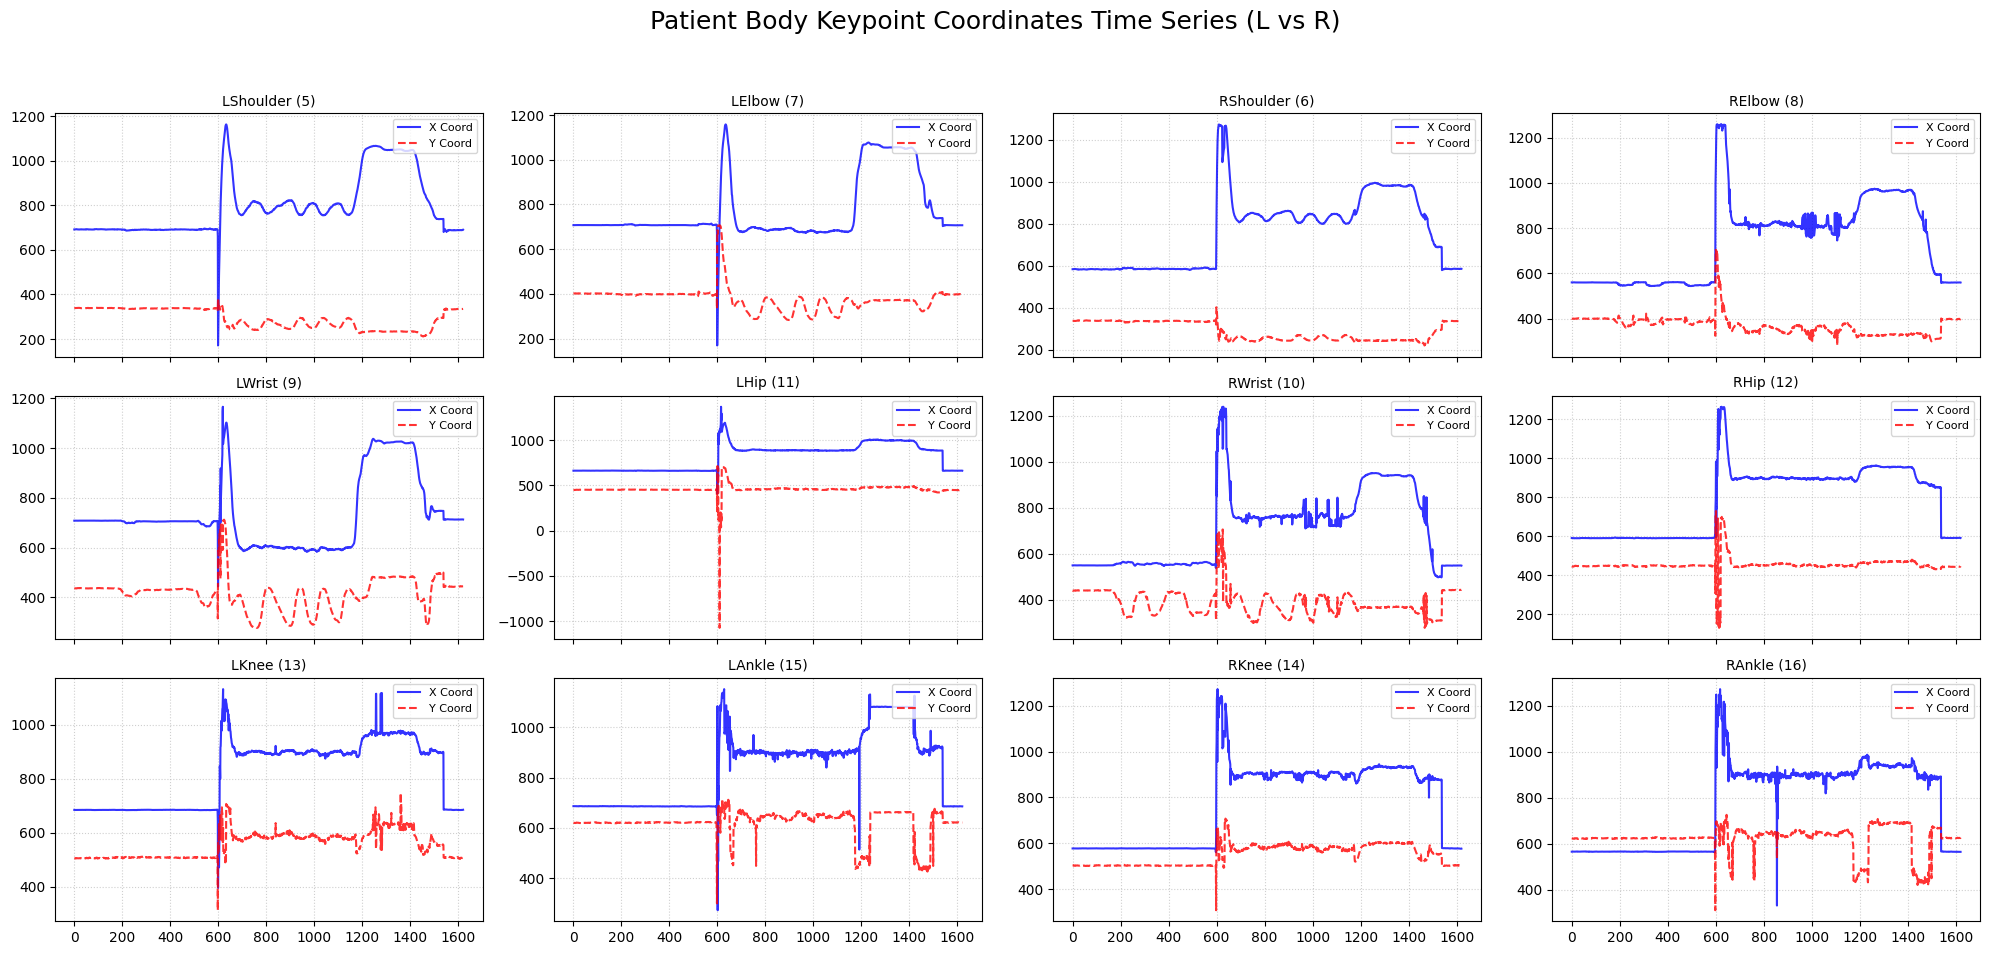

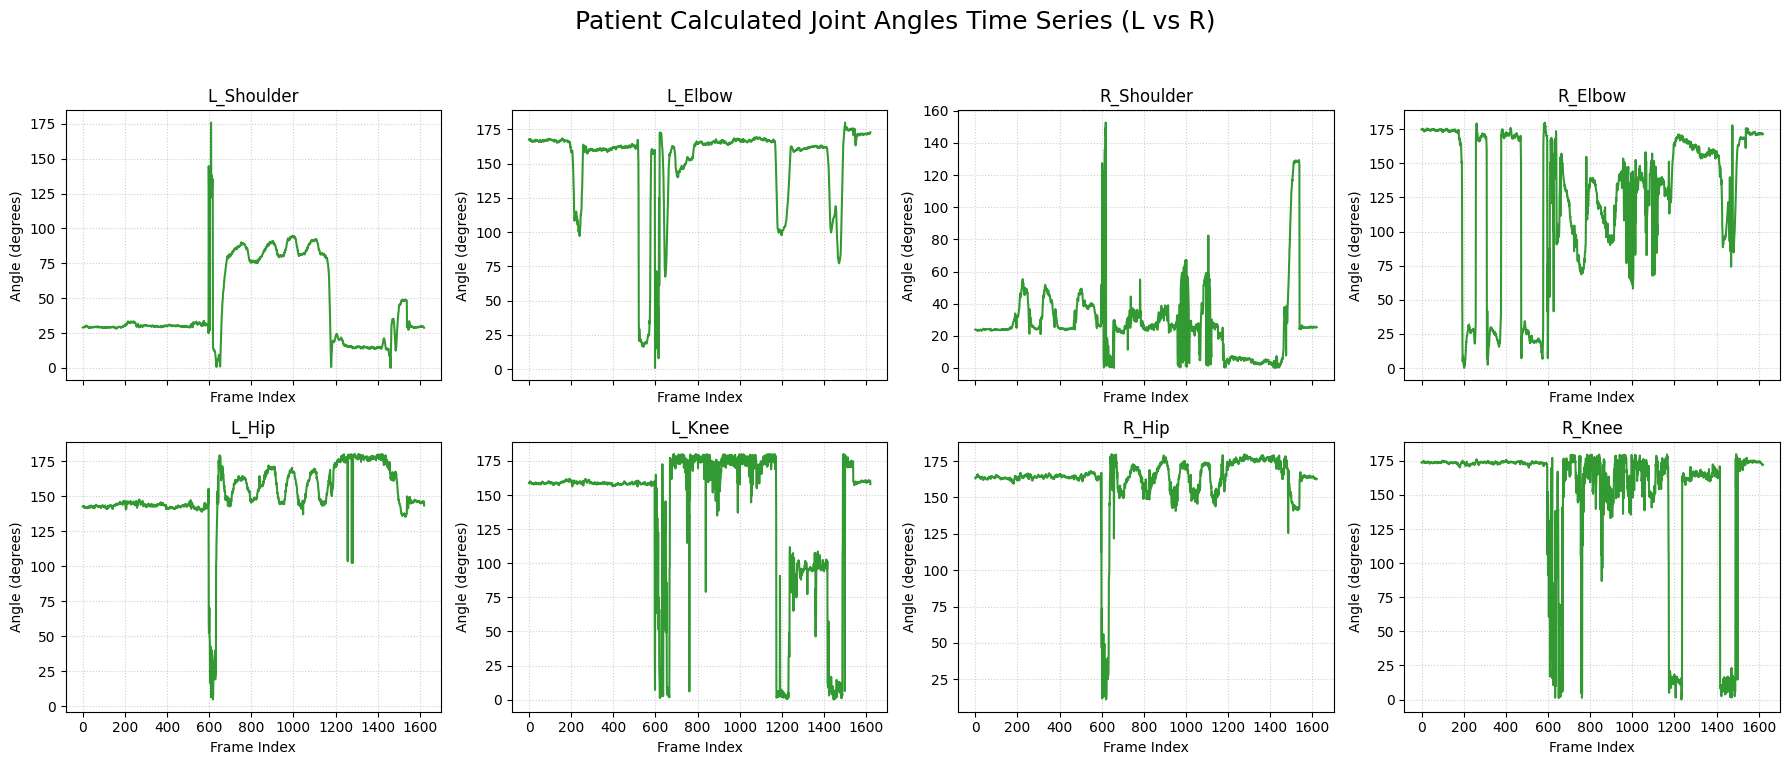

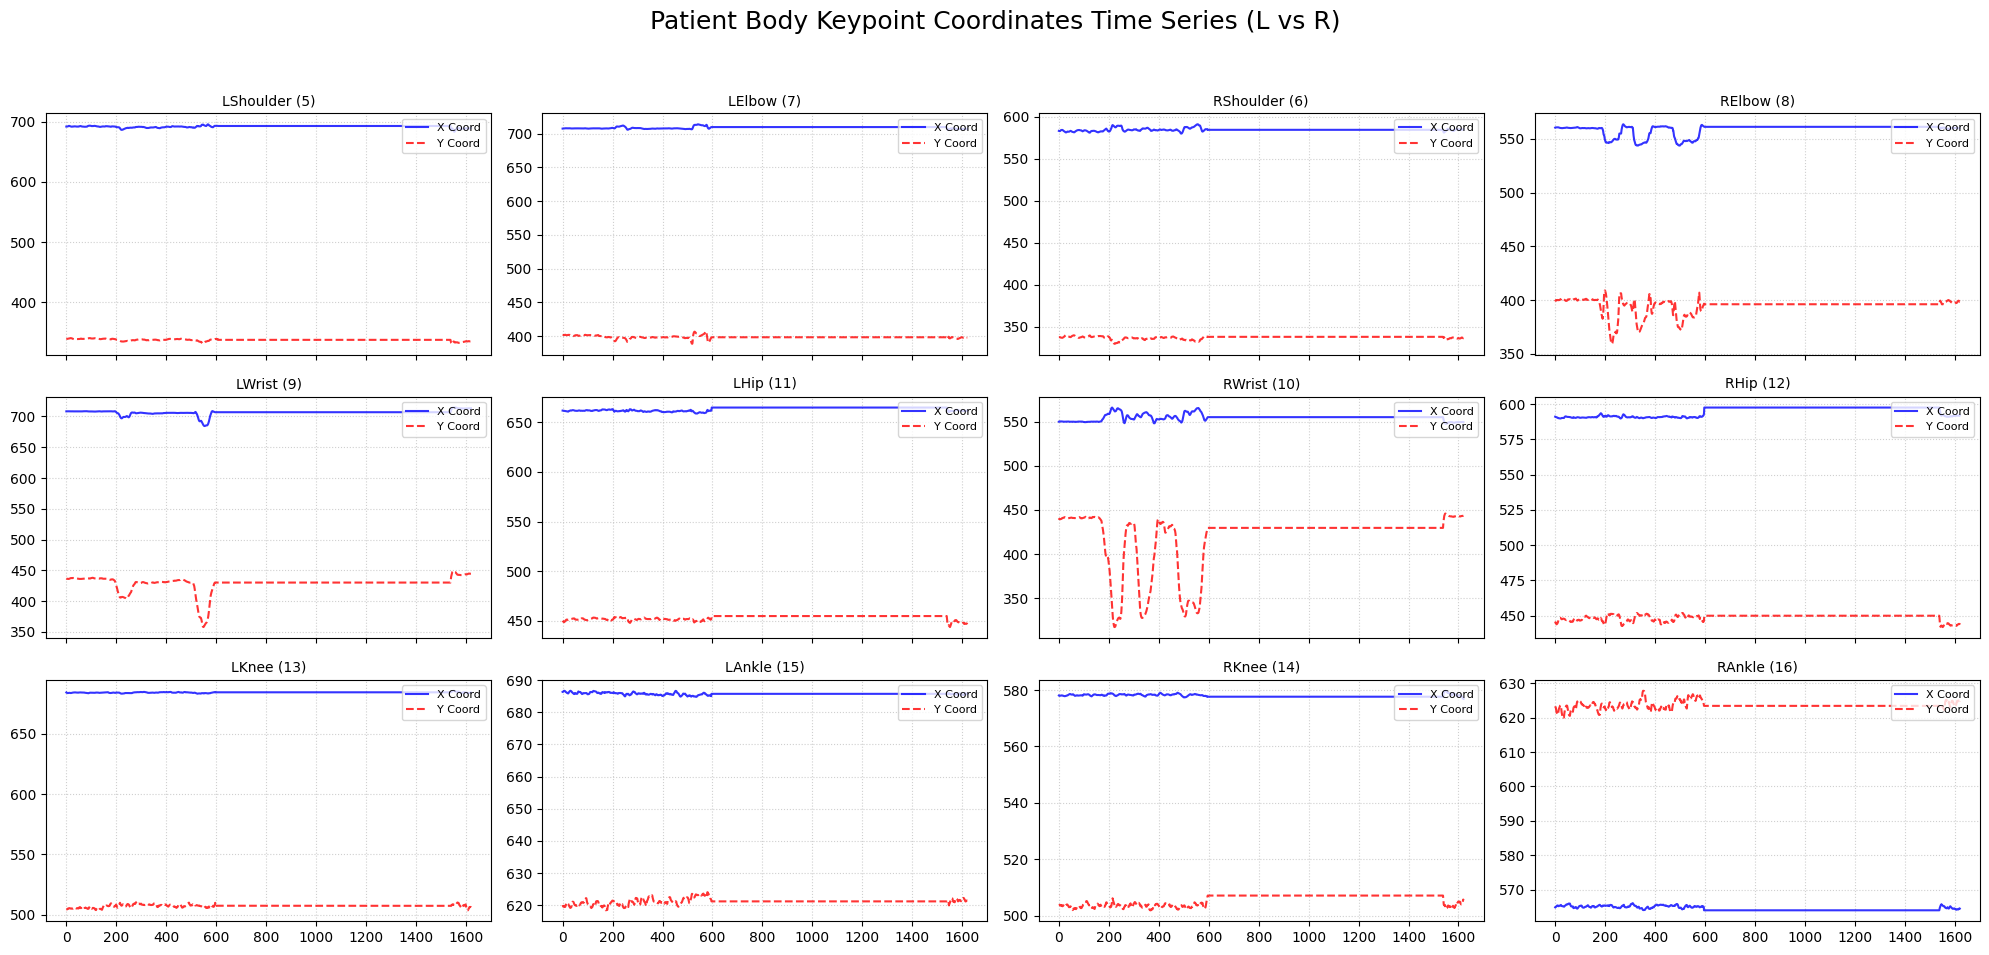

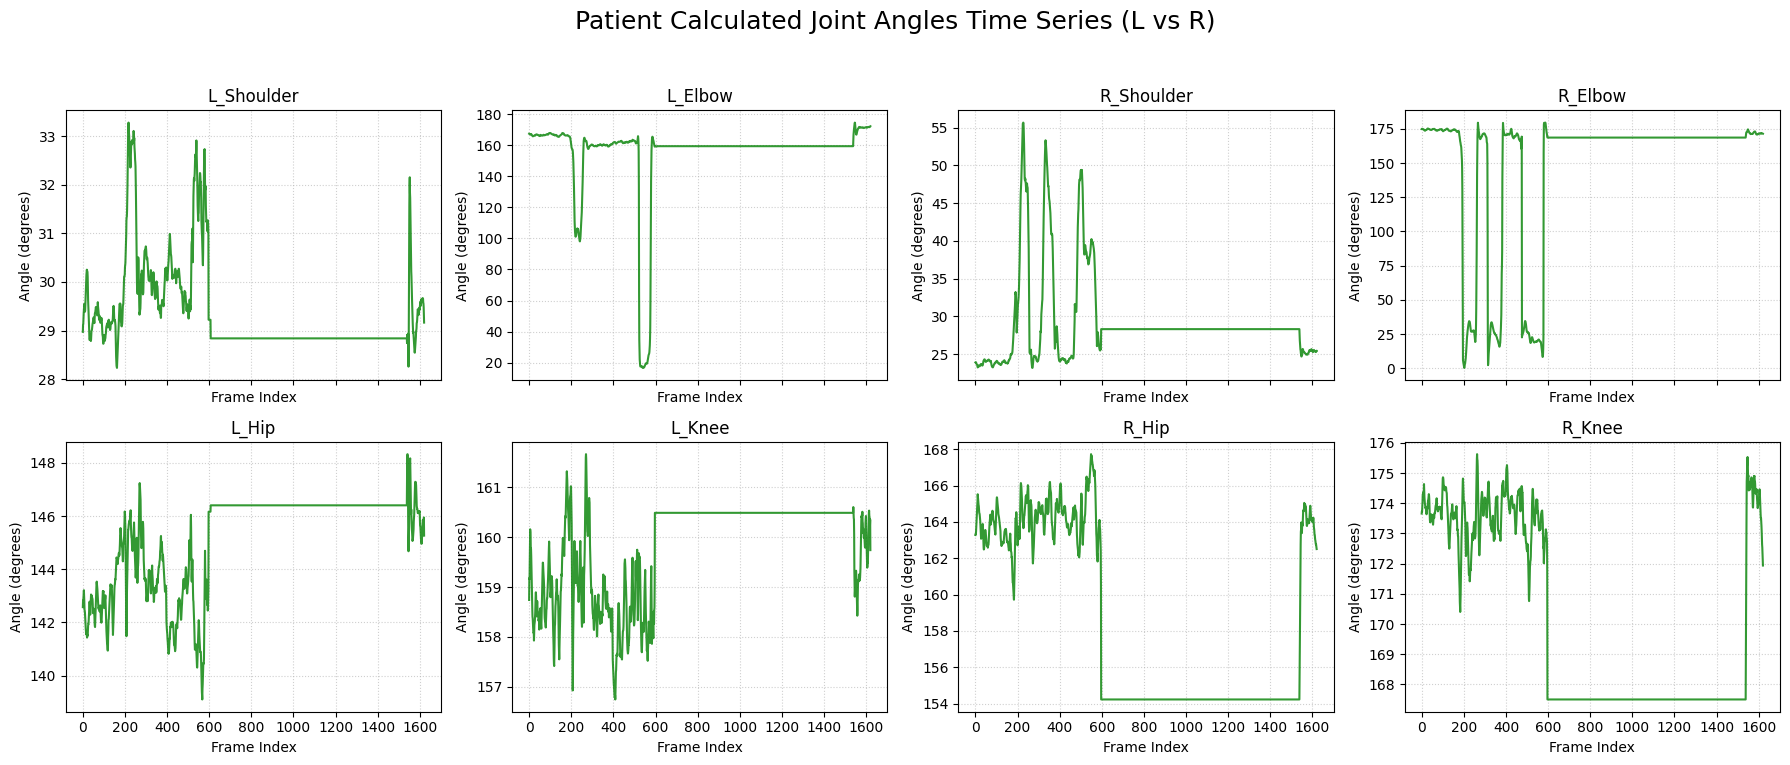

In [35]:
plot_keypoint_eda(noise_data)
plot_keypoint_eda(final_data)

# result

In [36]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from typing import Optional, List, Any, Tuple

# --- 💡 YOLO12 Keypoint Constants 적용 ---
# Keypoint 배열 형태: [frame, 12, 2+] (2+는 신뢰도/버디컬 등 포함)

COLOR_L = (255, 0, 0)       # Blue
COLOR_R = (0, 0, 255)       # Red
COLOR_NEUTRAL = (0, 255, 0) # Green (Neutral은 이 구조에서 사용되지 않음)
COLOR_SK = (50, 50, 50)     # Dark Gray

LEFT_POINTS = [0, 2, 4, 6, 8, 10]
RIGHT_POINTS = [1, 3, 5, 7, 9, 11]
EXCLUDE_POINTS = [] # 얼굴 없음

SKELETON_LINKS = [
    (10, 8), (8, 6),        # Left Leg: Ankle-Knee-Hip
    (11, 9), (9, 7),        # Right Leg: Ankle-Knee-Hip
    (6, 7),                 # Hip 연결
    (0, 6), (1, 7),         # Torso: Shoulder-Hip
    (0, 1),                 # Shoulder 연결
    (0, 2), (2, 4),         # Left Arm: Shoulder-Elbow-Wrist
    (1, 3), (3, 5)          # Right Arm: Shoulder-Elbow-Wrist
]
# ----------------------------------------------------

def render_skeleton_video_from_array(
    final_data: np.ndarray,      # <--- [frame, 12, 2+] 필터링된 키포인트 배열
    FRAME_PATH: str,           # <--- 원본 이미지 디렉토리 경로
    OUTPUT_PATH: str,          # <--- 출력 동영상 파일 경로
    start_frame: int,          # <--- 원본 이미지의 시작 프레임 번호 (예: 30)
    end_frame: int,            # <--- 원본 이미지의 종료 프레임 번호 (예: 130)
    fps: int = 30,
    kp_radius: int = 4,
    line_thickness: int = 2,
    flip_horizontal: bool = False
):
    """
    YOLO12 Keypoints 구조(12 kpts)를 사용하여 영상을 생성합니다.
    """
    
    frame_dir_path = Path(FRAME_PATH)
    out_mp4_path = Path(OUTPUT_PATH)
    out_mp4_path.parent.mkdir(parents=True, exist_ok=True)
    
    num_expected_frames = end_frame - start_frame + 1
    num_kpts_frames = final_data.shape[0]
    num_kpts_per_frame = final_data.shape[1]
    
    if num_kpts_frames != num_expected_frames:
        print(f"[ERROR] 키포인트 배열 크기가 구간과 일치하지 않습니다. 예상: {num_expected_frames}, 실제: {num_kpts_frames}")
        return
    if num_kpts_per_frame != 12:
        print(f"[ERROR] 키포인트 개수가 12개가 아닙니다. 실제: {num_kpts_per_frame}")
        return

    # 1. 처리할 프레임 파일 목록 결정
    frame_numbers = range(start_frame, end_frame + 1)
    frame_files_map = {fn: frame_dir_path / f"{fn:06d}.jpg" for fn in frame_numbers}
    
    valid_frame_paths = [p for p in frame_files_map.values() if p.exists()]
    
    if not valid_frame_paths:
        print(f"[WARN] No frame files exist in the specified range ({start_frame} to {end_frame}).")
        return

    # 2. 해상도 확인 및 VideoWriter 설정
    sample = cv2.imread(str(valid_frame_paths[0]))
    if sample is None:
        print(f"[ERROR] Could not read first valid frame: {valid_frame_paths[0]}")
        return
    
    h, w = sample.shape[:2]
    
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_mp4_path), fourcc, fps, (w, h))
    
    # 3. 키포인트 순회 및 렌더링
    for kpt_idx in tqdm(range(num_kpts_frames), total=num_kpts_frames,
                          desc=f"Rendering to {out_mp4_path.name}", unit="frame"):
        
        frame_num = start_frame + kpt_idx 
        frame_path = frame_files_map.get(frame_num)

        frame = cv2.imread(str(frame_path))
        if frame is None:
             continue
             
        kpts = final_data[kpt_idx] 
        
        # 4. 스켈레톤 라인 및 점 그리기
        
        # Skeleton 라인
        for i, j in SKELETON_LINKS:
            if i in EXCLUDE_POINTS or j in EXCLUDE_POINTS or i >= 12 or j >= 12:
                continue
            
            pt1_x, pt1_y = kpts[i, :2] 
            pt2_x, pt2_y = kpts[j, :2]

            # 유효성 검사 (0보다 큰 값)
            if pt1_x <= 0 or pt1_y <= 0 or pt2_x <= 0 or pt2_y <= 0:
                continue
                    
            pt1 = (int(pt1_x), int(pt1_y))
            pt2 = (int(pt2_x), int(pt2_y))
            cv2.line(frame, pt1, pt2, COLOR_SK, line_thickness)

        # Keypoints 점
        for idx, pt in enumerate(kpts):
            x, y = pt[:2]
            
            if idx in EXCLUDE_POINTS or x <= 0 or y <= 0:
                continue
                
            if idx in LEFT_POINTS:
                color = COLOR_L
            elif idx in RIGHT_POINTS:
                color = COLOR_R
            else:
                color = COLOR_NEUTRAL
                
            cv2.circle(frame, (int(x), int(y)), kp_radius, color, -1)
            
        # 5. 안내 문구 및 프레임 번호 표시
        legend_text = f"L: Blue | R: Red | Frame: {frame_num}"
        cv2.putText(frame, legend_text, (20, h - 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2, cv2.LINE_AA)

        # 6. 좌우 반전 (선택)
        if flip_horizontal:
            frame = cv2.flip(frame, 1)

        writer.write(frame)

    writer.release()
    print(f"✅ Skeleton overlay 완료 → {out_mp4_path}")

render_skeleton_video_from_array(
    final_data=final_data,
    FRAME_PATH=FRAME_PATH,
    OUTPUT_PATH=OUTPUT_PATH,
    start_frame=start_frame,
    end_frame=end_frame
)

Rendering to frontal__shoulder_flexion__1_test.mp4: 100% 1621/1621 [00:32<00:00, 49.83frame/s]


✅ Skeleton overlay 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/ASAN_01_Repeatition_Counter/frontal__shoulder_flexion__1_test.mp4


In [ ]:
import numpy as np
from typing import Dict, Any, Optional, List

# 전역 상수 (화질 및 ROI 설정)
FRAME_WIDTH = 1280
FRAME_HEIGHT = 720
ROI_CENTER = (FRAME_WIDTH // 2, FRAME_HEIGHT // 2)
ROI_TOLERANCE = 200 # 중앙에서 200픽셀 내의 영역

def extract_main_patient_data(tracking_data: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    """
    트래킹 데이터에서 중앙에 위치하며 가장 큰 BBox를 가진 환자를 식별하고,
    해당 환자의 데이터만 필터링하여 반환합니다.
    
    Returns:
        필터링된 tracking_data (메인 환자만 포함) 또는 None
    """
    frame_data_list = tracking_data.get('frame_data', [])
    if not frame_data_list:
        return None

    # 분석할 프레임 수 (초반 5프레임 분석)
    ANALYSIS_FRAMES = 30
    
    # {TID: [총 BBox 면적 합, 횟수]}
    tid_metrics = {}
    
    # 1. 초기 프레임 분석하여 메인 환자 TID 찾기
    for i, (frame_num, instances) in enumerate(frame_data_list):
        if i >= ANALYSIS_FRAMES:
            break

        for instance in instances:
            tid = instance.get('track_id')
            if tid is None:
                continue

            bbox = instance['bbox'][0] # [x1, y1, x2, y2]
            
            # 중앙 근접성 확인
            x1, y1, x2, y2 = bbox
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            
            # 중앙 ROI 기준 충족 여부
            is_central = (
                abs(center_x - ROI_CENTER[0]) < ROI_TOLERANCE and
                abs(center_y - ROI_CENTER[1]) < ROI_TOLERANCE
            )
            
            if is_central:
                # BBox 면적 계산
                bbox_area = (x2 - x1) * (y2 - y1)
                
                if tid not in tid_metrics:
                    tid_metrics[tid] = [0, 0] # [면적 합, 횟수]
                
                tid_metrics[tid][0] += bbox_area
                tid_metrics[tid][1] += 1

    if not tid_metrics:
        print("경고: 중앙 ROI 내에 적합한 인스턴스가 없습니다. (TID를 찾을 수 없음)")
        return None
    
    # 2. 평균 면적이 가장 큰 TID 선택 (기존 로직 유지)
    best_tid = max(
        tid_metrics, 
        key=lambda tid: tid_metrics[tid][0] / tid_metrics[tid][1] if tid_metrics[tid][1] > 0 else -1
    )
    
    
    # 3. 해당 TID 데이터만 필터링하여 NumPy 배열로 변환 (수정된 부분)
    all_kpts = []
    
    for frame_num, instances in tracking_data['frame_data']:
        # 해당 TID만 찾기 (next()를 사용하여 단일 인스턴스 검색)
        patient_instance = next(
            (inst for inst in instances if inst.get('track_id') == best_tid),
            None
        )
        
        if patient_instance and 'keypoints' in patient_instance:
            # 유효한 데이터가 있는 경우: 키포인트 (17, 2) 추출
            kpts = np.array(patient_instance['keypoints']) 
            all_kpts.append(kpts)
        else:
            # TID가 유실되거나 키포인트가 없는 경우: (17, 2) 크기의 NaN 배열로 채움
            all_kpts.append(np.full((17, 2), np.nan))

    # 최종 NumPy 배열 스택: (프레임 수, 17, 2)
    final_kpts_array = np.stack(all_kpts) 

    return final_kpts_array